In [1]:
import argparse
import time
import msgpack
from enum import Enum, auto

import numpy as np

from planning_utils import a_star, heuristic, create_grid
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local, local_to_global

In [2]:
class States(Enum):
    MANUAL = auto()
    ARMING = auto()
    TAKEOFF = auto()
    WAYPOINT = auto()
    LANDING = auto()
    DISARMING = auto()
    PLANNING = auto()


In [3]:
class MotionPlanning(Drone):

    def __init__(self, connection):
        super().__init__(connection)

        self.target_position = np.array([0.0, 0.0, 0.0])
        self.waypoints = []
        self.in_mission = True
        self.check_state = {}

        # initial state
        self.flight_state = States.MANUAL

        # register all your callbacks here
        self.register_callback(MsgID.LOCAL_POSITION, self.local_position_callback)
        self.register_callback(MsgID.LOCAL_VELOCITY, self.velocity_callback)
        self.register_callback(MsgID.STATE, self.state_callback)

    def local_position_callback(self):
        if self.flight_state == States.TAKEOFF:
            if -1.0 * self.local_position[2] > 0.95 * self.target_position[2]:
                self.waypoint_transition()
        elif self.flight_state == States.WAYPOINT:
            if np.linalg.norm(self.target_position[0:2] - self.local_position[0:2]) < 1.0:
                if len(self.waypoints) > 0:
                    self.waypoint_transition()
                else:
                    if np.linalg.norm(self.local_velocity[0:2]) < 1.0:
                        self.landing_transition()

    def velocity_callback(self):
        if self.flight_state == States.LANDING:
            if self.global_position[2] - self.global_home[2] < 0.1:
                if abs(self.local_position[2]) < 0.01:
                    self.disarming_transition()

    def state_callback(self):
        if self.in_mission:
            if self.flight_state == States.MANUAL:
                self.arming_transition()
            elif self.flight_state == States.ARMING:
                if self.armed:
                    self.plan_path()
            elif self.flight_state == States.PLANNING:
                self.takeoff_transition()
            elif self.flight_state == States.DISARMING:
                if ~self.armed & ~self.guided:
                    self.manual_transition()

    def arming_transition(self):
        self.flight_state = States.ARMING
        print("arming transition")
        self.arm()
        self.take_control()

    def takeoff_transition(self):
        self.flight_state = States.TAKEOFF
        print("takeoff transition")
        self.takeoff(self.target_position[2])

    def waypoint_transition(self):
        self.flight_state = States.WAYPOINT
        print("waypoint transition")
        self.target_position = self.waypoints.pop(0)
        print('target position', self.target_position)
        self.cmd_position(self.target_position[0], self.target_position[1], self.target_position[2], self.target_position[3])

    def landing_transition(self):
        self.flight_state = States.LANDING
        print("landing transition")
        self.land()

    def disarming_transition(self):
        self.flight_state = States.DISARMING
        print("disarm transition")
        self.disarm()
        self.release_control()

    def manual_transition(self):
        self.flight_state = States.MANUAL
        print("manual transition")
        self.stop()
        self.in_mission = False

    def send_waypoints(self):
        print("Sending waypoints to simulator ...")
        data = msgpack.dumps(self.waypoints)
        self.connection._master.write(data)

    def plan_path(self):
        self.flight_state = States.PLANNING
        print("Searching for a path ...")
        TARGET_ALTITUDE = 5
        SAFETY_DISTANCE = 5

        self.target_position[2] = TARGET_ALTITUDE

        # TODO: read lat0, lon0 from colliders into floating point values
        lat0, lon0, alt0 = 37.792480, -122.397450, 0.

        # TODO: set home position to (lon0, lat0, 0)
        self.set_home_position(longitude=lon0, latitude=lat0, altitude=alt0)

        # TODO: retrieve current global position
        global_home_pose = np.array([lon0, lat0, alt0])

        # TODO: convert to current local position using global_to_local()
        start_ne = global_to_local(self.global_position, self.global_home)
        
        print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                         self.local_position))
        # Define start and goal locations
        start = (int(start_ne[0]), int(start_ne[1])) # current drone position
        goal = (150, 10) # arbitrary position on the map, [m]
        
        # Read in obstacle map
        data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
        
        # Define a grid for a particular altitude and safety margin around obstacles
        grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
        print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))
        # Define starting point on the grid (this is just grid center)
        grid_start = (start[0]-north_offset, start[1]-east_offset)
        # TODO: convert start position to current position rather than map center
        
        # Set goal as some arbitrary position on the grid
        grid_goal = (goal[0]-north_offset, goal[1]-east_offset)
        # TODO: adapt to set goal as latitude / longitude position and convert

        # Run A* to find a path from start to goal
        # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
        # or move to a different search space such as a graph (not done here)
        print('Local Start and Goal: ', grid_start, grid_goal)
        path, _ = a_star(grid, heuristic, grid_start, grid_goal)
        
        # TODO: prune path to minimize number of waypoints
        # TODO (if you're feeling ambitious): Try a different approach altogether!

        # Convert path to waypoints
        waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path]
        # Set self.waypoints
        self.waypoints = waypoints
        # TODO: send waypoints to sim
        self.send_waypoints()

    def start(self):
        self.start_log("Logs", "NavLog.txt")

        print("starting connection")
        self.connection.start()

        # Only required if they do threaded
        # while self.in_mission:
        #    pass

        self.stop_log()


In [4]:
conn = MavlinkConnection('tcp:127.0.0.1:5760', timeout=60)

In [5]:
drone = MotionPlanning(conn)

Logs/TLog.txt


In [9]:
time.sleep(1)

In [10]:
drone.start()

Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.3974533   37.7924804    0.       ], position [-1.22397336e+02  3.77938344e+01  9.70000000e-02], local position [ 1.50446487e+02  1.03818130e+01 -9.75595340e-02]
North offset = -316, east offset = -445
Local Start and Goal:  (466, 454) (466, 455)
Found a path.
Sending waypoints to simulator ...
takeoff transition
waypoint transition
target position [150, 9, 5, 0]
waypoint transition
target position [150, 10, 5, 0]
landing transition
disarm transition
manual transition
Closing connection ...


### Path construction tests

#### Path prunning

In [6]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

# We're using collinearity here, but you could use Bresenham as well!
def prune_path(path, eps=1e-6):
    pruned_path = [p for p in path]
    # TODO: prune the path!
    
    i = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        
        # If the 3 points are in a line remove
        # the 2nd point.
        # The 3rd point now becomes and 2nd point
        # and the check is redone with a new third point
        # on the next iteration.
        if collinearity_check(p1, p2, p3, eps):
            # Something subtle here but we can mutate
            # `pruned_path` freely because the length
            # of the list is check on every iteration.
            pruned_path.remove(pruned_path[i+1])
        else:
            i += 1
    return pruned_path

In [39]:
TARGET_ALTITUDE = 5
SAFETY_DISTANCE = 5

# TODO: read lat0, lon0 from colliders into floating point values
lat0, lon0, alt0 = 37.792480, -122.397450, 0.

# TODO: set home position to (lon0, lat0, 0)
drone.set_home_position(longitude=lon0, latitude=lat0, altitude=alt0)

# TODO: retrieve current global position
global_home_pose = np.array([lon0, lat0, alt0])

# TODO: convert to current local position using global_to_local()
start_ne = global_to_local(drone.global_position, drone.global_home)

print('global home {0}, position {1}, local position {2}'.format(drone.global_home, drone.global_position,
                                                             drone.local_position))

# Read in obstacle map
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)

# Define a grid for a particular altitude and safety margin around obstacles
grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))

# Define starting point on the grid (this is just grid center)
# TODO: convert start position to current position rather than map center
grid_start = (int(start_ne[0])-north_offset, int(start_ne[1])-east_offset)
grid_goal = (200-north_offset, 200-east_offset)

# # Set goal as some arbitrary position on the grid
# goal_x = np.random.randint(0, grid.shape[0])
# goal_y = np.random.randint(0, grid.shape[1])
# while grid[goal_x, goal_y] == 1:
#     goal_x = np.random.randint(0, grid.shape[0])
#     goal_y = np.random.randint(0, grid.shape[1])
# grid_goal = (goal_x, goal_y)

# TODO: adapt to set goal as latitude / longitude position and convert
# angular_range = 0.005
# lat_goal = lat0 + (2*np.random.rand()-1)*angular_range
# lon_goal = lon0 + (2*np.random.rand()-1)*angular_range
# alt_goal = -TARGET_ALTITUDE
# global_goal_pose = np.array([lon_goal, lat_goal, alt_goal])
# goal_ne = global_to_local(global_goal_pose, global_home_pose)
# goal_x, goal_y = int(goal_ne[0])-north_offset, int(goal_ne[1])-east_offset
# while grid[goal_x, goal_y] == 1:
#     lat_goal = lat0 + (2*np.random.rand()-1)*angular_range
#     lon_goal = lon0 + (2*np.random.rand()-1)*angular_range
#     alt_goal = -TARGET_ALTITUDE
#     global_goal_pose = np.array([lon_goal, lat_goal, alt_goal])
#     goal_ne = global_to_local(global_goal_pose, global_home_pose)
#     goal_x, goal_y = int(goal_ne[0])-north_offset, int(goal_ne[1])-east_offset
# grid_goal = (goal_x, goal_y)
    
    
# Run A* to find a path from start to goal
# TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
# or move to a different search space such as a graph (not done here)
print('Local Start and Goal: ', grid_start, grid_goal)
path, _ = a_star(grid, heuristic, grid_start, grid_goal)

# # # TODO: prune path to minimize number of waypoints
# # # TODO (if you're feeling ambitious): Try a different approach altogether!

# # # Convert path to waypoints
waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path]

prunned_path = prune_path(path, 0.5)
print('Path length: {0}, prunned path length: {1}'.format(len(path), len(pruned_path)))

global home [0 0 0], position [0 0 0], local position [0. 0. 0.]
North offset = -316, east offset = -445
Local Start and Goal:  (316, 445) (516, 645)
Found a path.
Path length: 401, prunned path length: 30


#### Visualization

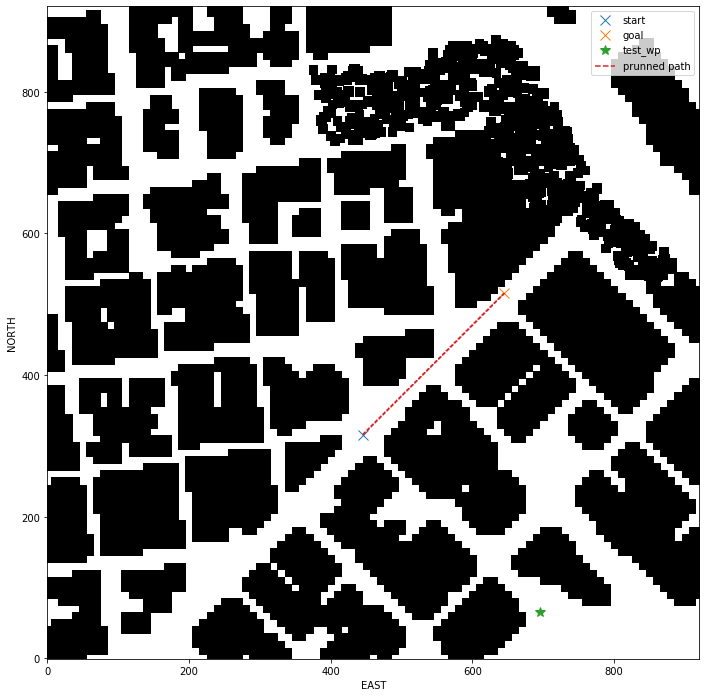

In [48]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 12

plt.imshow(grid, cmap='Greys', origin='lower')

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(grid_start[1], grid_start[0], 'x', markersize=10, label='start')
plt.plot(grid_goal[1], grid_goal[0], 'x', markersize=10, label='goal')
plt.plot(250-east_offset, -250-north_offset, '*', markersize=10, label='test_wp')

if path is not None:
#     path = np.array(path)
#     plt.plot(path[:, 1], path[:, 0], 'g', linewidth=4, label='path')
    pp = np.array(prunned_path)
    plt.plot(pp[:, 1], pp[:, 0], '--', label='prunned path')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.legend()
plt.show()

### Local APF

In [50]:
def attraction(position, goal, alpha):
    # TODO: implement attraction force
    position = np.array(position)
    goal = np.array(goal)
    return -alpha*(position - goal)

In [49]:
def repulsion(position, obstacle, beta, q_max):
    # TODO: implement replusion force
    position = np.array(position)
    obstacle = np.array(obstacle)
    return beta*(1./q_max - 1./np.linalg.norm(position-obstacle)) * 1./(np.linalg.norm(position-obstacle)**2)

In [80]:
def potential_field(grid, goal, alpha=1.0, beta=2.0, q_max=10.0):
    x = []
    y = []
    fx = []
    fy = []
    
    obs_i, obs_j = np.where(grid == 1)

    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if grid[i, j] == 0:
                
                # add attraction force
                force = attraction([i, j], goal, alpha)

                for (oi, oj) in zip(obs_i, obs_j):
                    if np.linalg.norm(np.array([i, j]) - np.array([oi, oj])) < q_max:
                        # add repulsion force
                        force += repulsion([i, j], [oi, oj], beta, q_max)
                    
                x.append(i)
                y.append(j)
                fx.append(force[0])
                fy.append(force[1])

    return x, y, fx, fy

In [81]:
local_grid = grid[-40-north_offset:-north_offset+40, -40-east_offset:-east_offset+40]
x, y, fx, fy = potential_field(local_grid, (10,10))

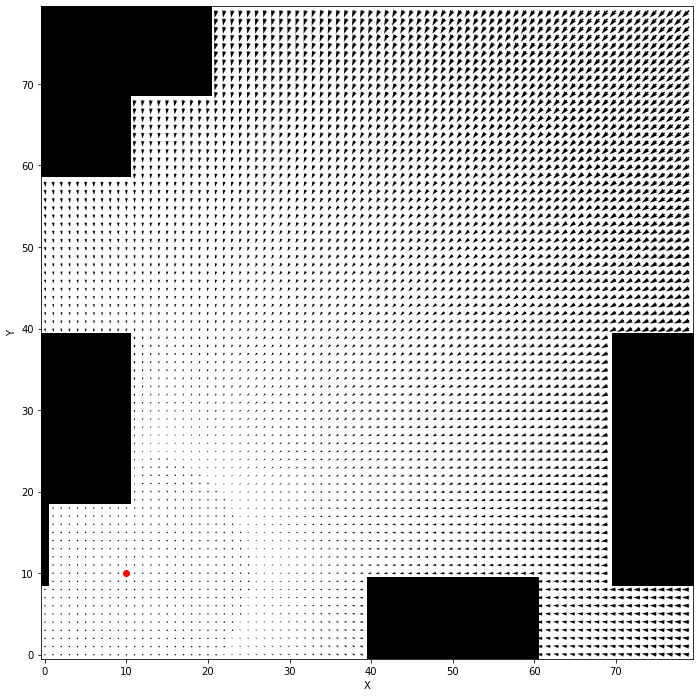

In [82]:
plt.imshow(local_grid, cmap='Greys', origin='lower')
plt.plot(10, 10, 'ro')
plt.quiver(y, x, fy, fx)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()